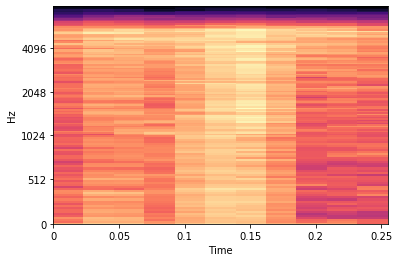

In [20]:
import librosa
from librosa import display
from IPython.display import Audio
import numpy as np
import torch


import glob
    
file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

sr = 5000

y, sr = librosa.load("output/damselfish/0.wav", sr=sr)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2560, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)

sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
#librosa.display.specshow(sg2)

db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')

#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

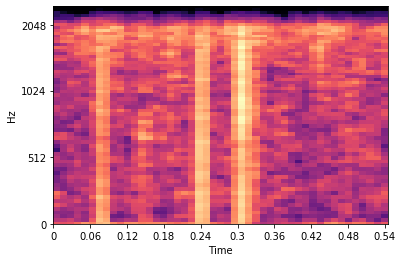

In [21]:
import glob
    
file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

y, sr = librosa.load(
    "./output/damselfish/0.wav",
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

#sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

In [6]:
from fastai_audio.audio import *

path = Path("output/")

#sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=1024, hop_length=256, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
#db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-04, top_db=40.0)
#librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

sg_cfg = SpectrogramConfig(n_fft=2560, hop=512, n_mels=512, top_db=60, f_max=2500)

config = AudioConfig(
    use_spectro=True,
    sg_cfg=sg_cfg,
    max_to_pad=1000
)

#label_pattern = r'_([mf]\d+)_'
al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
#al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_const("damselfish")

In [7]:
tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
db = al.transform(tfms).databunch(bs=64)
db.show_batch(rows=3)

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 0.67 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (512x10):
------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 0.78 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (512x10):
------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 0.8 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (512x10):


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


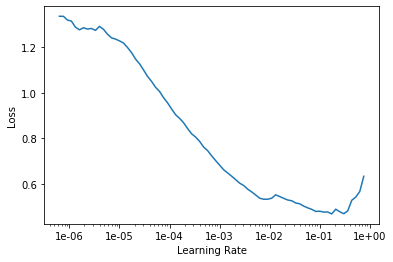

In [31]:
learn = audio_learner(db)

#learn = cnn_learner(db, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

#learn = cnn_learner(db, models.densenet161, metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(100, slice(1e-5, 1e-3))


epoch,train_loss,valid_loss,accuracy,time
0,1.213355,0.677456,0.560976,00:01
1,0.978738,0.471204,0.768293,00:01
2,0.837720,0.759991,0.719512,00:01
3,0.773687,1.059144,0.743902,00:01
4,0.695950,1.071958,0.756098,00:01
5,0.627737,0.932883,0.804878,00:01
6,0.583774,0.784277,0.829268,00:01
7,0.533729,0.638398,0.865854,00:01
8,0.484130,0.536663,0.878049,00:01
9,0.445793,0.509689,0.890244,00:01


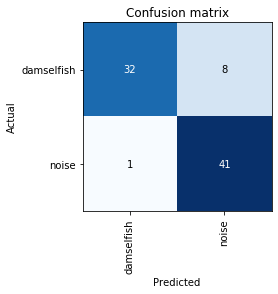

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(100, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.000276,0.764297,0.890244,00:01
1,0.000578,0.766215,0.890244,00:01
2,0.000391,0.786117,0.878049,00:01
3,0.000475,0.790177,0.878049,00:01
4,0.000391,0.816299,0.878049,00:01
5,0.000348,0.793171,0.878049,00:01
6,0.000292,0.783812,0.890244,00:01
7,0.000300,0.774390,0.890244,00:01
8,0.000257,0.751039,0.902439,00:01
9,0.000220,0.779367,0.902439,00:01


In [41]:
learn.save('/workspaces/sonumator/stage1')

In [9]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage1")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [17]:
item = AudioItem(path="output/damselfish/31.wav")
al = AudioList.from_folder("/tmp/test_data/", config=config, ignore_empty=True).split_none().label_empty()

audio_predict(learn, item)

AssertionError: 